In [1]:
import os
os.environ['JAX_ENABLE_X64'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.1'

%matplotlib widget
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
from temgym_core.components import Detector
from temgym_core.gaussian import GaussianRayBeta
from temgym_core.utils import fibonacci_spiral

from temgym_core.gaussian_taylor import (
    Biprism,
    Lens,
    run_to_end
)
from abtem.core.energy import energy2wavelength
from temgym_core.evaluate import eval_gaussians_gpu_kernel_wrapper, evaluate_gaussians_jax_scan, evaluate_gaussians_for

In [2]:
scale = 1
aperture_window_width = 0.1e-6 * scale
num_aper_pixels = 256
aperture_pixel_size = (aperture_window_width / num_aper_pixels, aperture_window_width / num_aper_pixels)
aperture_radius = 50e-9 * scale

num_rays = int(1)
rx, ry = fibonacci_spiral(nb_samples=num_rays, radius=aperture_radius, alpha=0)

voltage = 200e3  # in eV
wavelength = energy2wavelength(200e3) / 1e10 # angstrom to metres
k0 = 2 * np.pi / wavelength
w0 = 1e-9 * scale
aperture_area = np.pi * aperture_radius**2
scale_factor = aperture_area / (w0 ** 2 * num_rays * np.pi)

In [3]:
w0 = 1e-9
q = -1j * (2.0 / (k0 * w0**2))
Q_inv = jnp.array([[q, 0.0], [0.0, q]])
Q_inv = jnp.tile(Q_inv, (num_rays, 1, 1))

C0 = jnp.ones(num_rays) * (1.0 * scale_factor + 0.0j)
eta = jnp.full((num_rays, 2), 0.0+0.0j)
voltage_arr = jnp.full((num_rays,), voltage)

rays_in = GaussianRayBeta(x=rx + 5e-9,
                         y=ry,
                         dx=jnp.zeros(num_rays),
                         dy=jnp.zeros(num_rays),
                         z=jnp.zeros(num_rays),
                         pathlength=jnp.zeros(num_rays),
                         Q_inv=Q_inv,
                         eta=eta,
                         C=C0,
                         voltage=voltage_arr)

print(rays_in.wavelength)
input_aperture_grid = Detector(
    pixel_size=aperture_pixel_size,
    shape=(num_aper_pixels, num_aper_pixels),
    z=0.0,
)
x, y = input_aperture_grid.coords_1d
extent = (x.min(), x.max(), y.min(), y.max())

[2.50793403e-12]


In [4]:
aperture_image = eval_gaussians_gpu_kernel_wrapper(rays_in, input_aperture_grid)

Text(0.5, 1.0, 'Aperture Plane Amplitude')

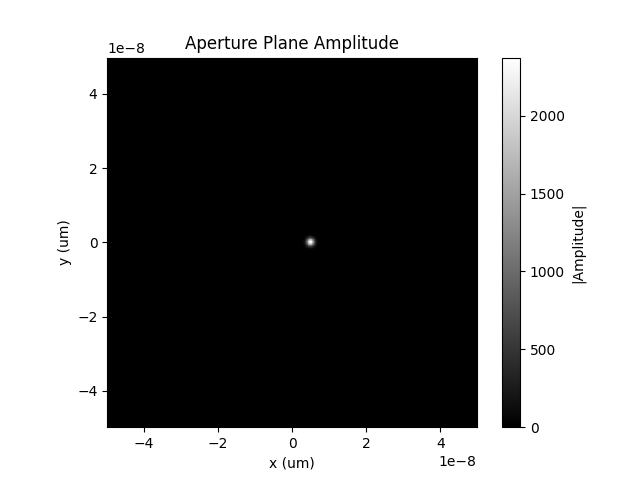

In [5]:
plt.figure()
plt.imshow(jnp.abs(aperture_image), cmap='gray', extent=extent)
plt.xlabel('x (um)')
plt.ylabel('y (um)')
plt.colorbar(label='|Amplitude|')
plt.title('Aperture Plane Amplitude')

In [6]:
M1 = -300
F1 = 0.0025
M2 = -1500
F2 = 0.02
defocus = 0.0
L1_z1 = F1 * (1/M1 - 1)
L1_z2 = F1 * (1 - M1)
L2_z1 = F2 * (1/M2 - 1)
L2_z2 = F2 * (1 - M2)
L1_z1, L1_z2, L2_z1, L2_z2 = np.abs([L1_z1, L1_z2, L2_z1, L2_z2])

detector_pixel_size = (aperture_pixel_size[0] * abs(M1), aperture_pixel_size[1] * abs(M1))
lens1 = Lens(focal_length=F1, z=L1_z1)
# biprism = Biprism(z=L1_z1 + L1_z2 / 2, theta=0.0, strength=-2e-5, width=1e-9)
# lens2 = Lens(focal_length=F2, z=L1_z1 + L1_z2 + L2_z1)
detector = Detector(z=L1_z1 + L1_z2, pixel_size=detector_pixel_size, shape=(num_aper_pixels, num_aper_pixels))
det_x, det_y = detector.coords_1d
det_extent = (det_x.min(), det_x.max(), det_y.min(), det_y.max())
model = [lens1, detector]

In [7]:
det_rays = run_to_end(rays_in, model)

In [8]:
print(rays_in.Q_inv)
print(det_rays.Q_inv)

print(waist_true := w0 * abs(M1))

q1_imag = det_rays.Q_inv[0, 0,0].imag
print(waist_calc := np.sqrt(-wavelength / (np.pi * q1_imag)))



[[[0.-798300.19619734j 0.     +0.j        ]
  [0.     +0.j         0.-798300.19619734j]]]
[[[1.33333333-8.87000218j 0.        +0.j        ]
  [0.        +0.j         1.33333333-8.87000218j]]]
3.0000000000000004e-07
3.000000000000001e-07


In [9]:
detector_image = evaluate_gaussians_for(det_rays, detector)
# detector_image = eval_gaussians_gpu_kernel_wrapper(det_rays, detector)

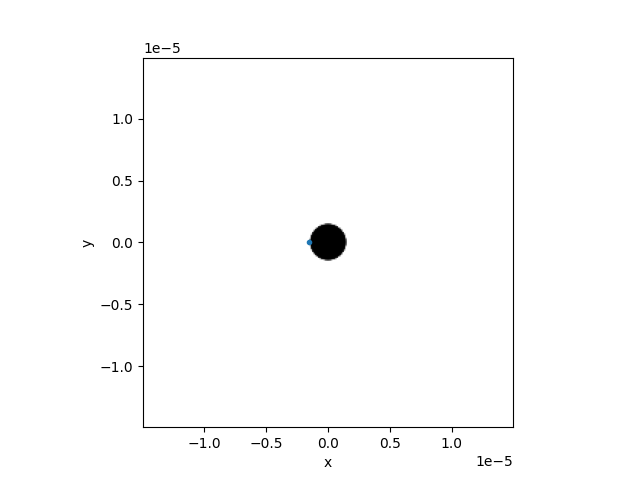

In [10]:
ray_step = 1
plt.figure()
plt.imshow(jnp.abs(detector_image), cmap='gray', extent=det_extent)
plt.xlabel('x')
plt.ylabel('y')
plt.plot(det_rays.x, det_rays.y, '.')